# Conclusiones

## Índice de Contenido

1. [Preparación del entorno y carga de datos](#1-preparación-del-entorno-y-carga-de-datos)
    - [Reproducción del modelo original](#reproducimos-el-modelo-usado-en-la-notebook-3-entrenando-un-primer-modelo)
    - [Reproducción del modelo mitigado](#reproducimos-el-modelo-mitigado-usando-in-processing-prejudiceremover)
2. [Comparación de resultados](#2-comparación-de-resultados)
    - [Matrices generales](#21-modelos-en-general)
    - [Matrices por grupo](#22-matrices-de-confusión-por-grupo)
    - [Gráfico en conjunto](#23-gráfico-en-conjunto)

## 1. Preparación del entorno y carga de datos

In [1]:
import os

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from holisticai.bias.mitigation import PrejudiceRemover

In [2]:
# Carga de datos
german_credit_csv_fqdn = os.path.join("..", "data", "processed", "df_genero_procesado.csv")
german_credit_df = pd.read_csv(german_credit_csv_fqdn)

### Reproducimos el modelo usado en la notebook 3 "Entrenando un primer modelo"

In [3]:
# Separar atributos, target e índices
X = german_credit_df.drop(columns=["target"], axis=1)
y = german_credit_df["target"]
idxs = X.index

# Train/Test split
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X.values,
    y.values,
    idxs,
    test_size=0.2,
    random_state=42
)

X_test = pd.DataFrame(X_test, columns=X.columns, index=idx_test)
y_test = pd.Series(y_test, name='target', index=idx_test)
X_train = pd.DataFrame(X_train, columns=X.columns, index=idx_train)
y_train = pd.Series(y_train, name='target', index=idx_train)

# Modelo baseline
scaler = StandardScaler()
baseline_model = LogisticRegression(
    random_state=42,
    max_iter=1000
)
pipe = Pipeline(
    [("Scaler", scaler),
    (("Baseline"), baseline_model)]
)
pipe.fit(X_train, y_train)

# Resultados del modelo baseline
y_pred_test = pipe.predict(X_test)
print("\tModelo Baseline: LogisticRegressor de scikit-learn\n\tReporte de clasificación\n\n", classification_report(y_true=y_test, y_pred=y_pred_test))

	Modelo Baseline: LogisticRegressor de scikit-learn
	Reporte de clasificación

               precision    recall  f1-score   support

           0       0.66      0.42      0.52        59
           1       0.79      0.91      0.84       141

    accuracy                           0.77       200
   macro avg       0.72      0.67      0.68       200
weighted avg       0.75      0.77      0.75       200



### Reproducimos el modelo mitigado usando _In-Processing_ _PrejudiceRemover_

In [4]:
# Necesito separar a los grupos de la variable sensible para fittear y predecir con PrejudiceRemover
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

group_a_train = X_train['genre_male'] == 1
group_b_train = X_train['genre_male'] == 0
group_a_test = X_test['genre_male'] == 1
group_b_test = X_test['genre_male'] == 0

# Modelo con mitigación
mitigator = PrejudiceRemover(
    maxiter=100,
    fit_intercept=True,
    print_interval=1
).transform_estimator(baseline_model)
mitigator.fit(X_train_scaled, y_train, group_a_train, group_b_train)

# Resultados del modelo con mitigación
y_mitigated_pred_test = mitigator.predict(X_test_scaled, group_a_test, group_b_test)
print("\tModelo Mitigado: PrejudiceRemover de holisticai\n\tReporte de clasificación\n\n", classification_report(y_true=y_test, y_pred=y_mitigated_pred_test))

	Modelo Mitigado: PrejudiceRemover de holisticai
	Reporte de clasificación

               precision    recall  f1-score   support

           0       0.68      0.42      0.52        59
           1       0.79      0.91      0.85       141

    accuracy                           0.77       200
   macro avg       0.73      0.67      0.68       200
weighted avg       0.76      0.77      0.75       200



## 2. Comparación de resultados

### 2.1 Modelos en general

In [5]:
# Generamos y juntamos las matrices de consufión para graficarlas
cm_baseline = confusion_matrix(
    y_test,
    y_pred_test,
    labels=[1, 0]
)

cm_mitigated = confusion_matrix(
    y_test,
    y_mitigated_pred_test,
    labels=[1, 0]
)

matrices = {
    "Modelo baseline": cm_baseline,
    "Modelo mitigado": cm_mitigated
}

### 2.2 Matrices de confusión por grupo

In [6]:
# Índices de los grupos
idx_group_0 = y_test.index[y_test.index.isin(idx_test) & (group_a_test == False)]
idx_group_1 = y_test.index[y_test.index.isin(idx_test) & (group_a_test == True)]
y_test_female = y_test.loc[idx_group_0]
y_test_male = y_test.loc[idx_group_1]
y_pred_test_female = y_pred_test[[i for i, idx in enumerate(idx_test) if idx in idx_group_0]]
y_pred_test_male = y_pred_test[[i for i, idx in enumerate(idx_test) if idx in idx_group_1]]
y_mitigated_pred_test_female = y_mitigated_pred_test[[i for i, idx in enumerate(idx_test) if idx in idx_group_0]]
y_mitigated_pred_test_male = y_mitigated_pred_test[[i for i, idx in enumerate(idx_test) if idx in idx_group_1]]

# Para el modelo sin mitigación
cm_female = confusion_matrix(
    y_test_female,
    y_pred_test_female,
    labels=[1, 0]
)
cm_male = confusion_matrix(
    y_test_male,
    y_pred_test_male,
    labels=[1, 0]
)

# Para el modelo mitigado
cm_mitigated_female = confusion_matrix(
    y_test_female,
    y_mitigated_pred_test_female,
    labels=[1, 0]
)
cm_mitigated_male = confusion_matrix(
    y_test_male,
    y_mitigated_pred_test_male,
    labels=[1, 0]
)

matrices.update({
    "Modelo baseline para mujeres": cm_female,
    "Modelo mitigado para mujeres": cm_mitigated_female,
    "Modelo baseline para hombres": cm_male,
    "Modelo mitigado para hombres": cm_mitigated_male
})

### 2.3 Gráfico en conjunto

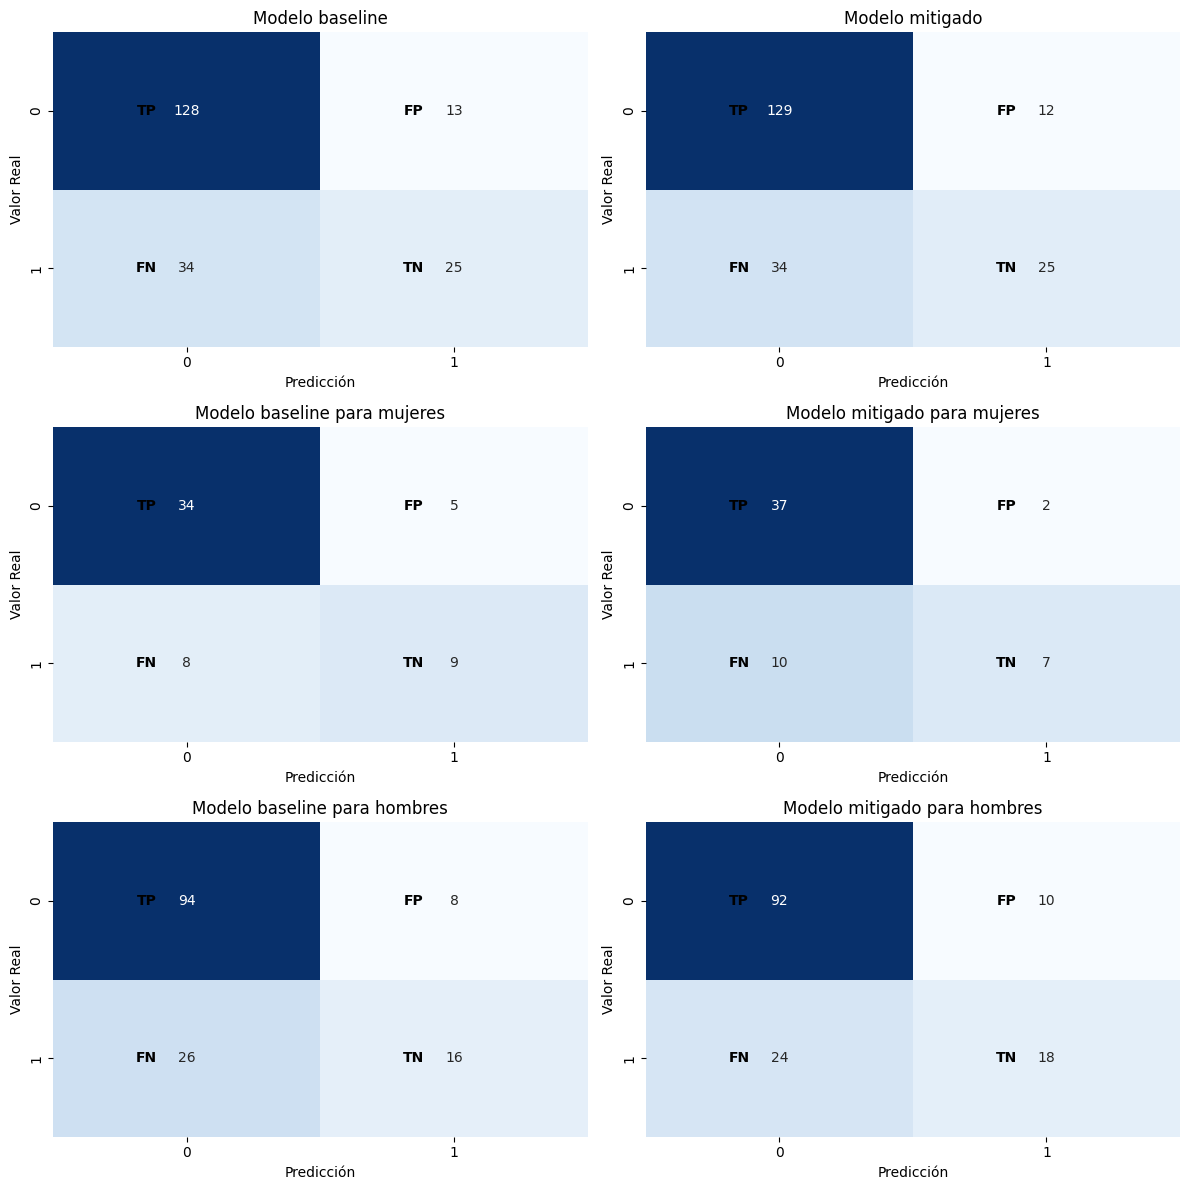

In [7]:
# Visualizamos las matrices de confusión
fig, ax = plt.subplots(3, 2, figsize=(12, 12))
ax = ax.ravel()

i = 0
for titulo, matriz in matrices.items():
    current_ax = ax[i]
    sns.heatmap(
        matriz,
        annot=True,
        fmt="d",
        cmap="Blues",
        ax=current_ax,
        cbar=False
    )
    for (j, k), val in np.ndenumerate(matriz):
        if j == 0 and k == 0:
            label = "TP"
        elif j == 1 and k == 0:
            label = "FN"
        elif j == 0 and k == 1:
            label = "FP"
        else:
            label = "TN"
        current_ax.text(k + 0.35, j + 0.45, f"\n{label}", color="black", ha="center", va="center", fontsize=10, fontweight="bold")
    current_ax.set_title(titulo)
    current_ax.set_xlabel("Predicción")
    current_ax.set_ylabel("Valor Real")
    i = i+1

plt.tight_layout()
plt.show()

El modelo entrenado con `PrejudiceRemover` mejoró la _performance_ para el grupo de mujeres, incrementando la cantidad de Positivos Verdaderos (TP, _True Positive_) en 3 casos, además de mejorar en 1 caso los TP del modelo en general. Se pierde un poco la perfomance del grupo privilegiado en el modelo basae, pero se gana en _fairness_, (equidad o igualdad) para los grupos estudiados.